# Engineering Predictive Alpha Factors

This notebook illustrates the following steps:

1. Select the adjusted open, high, low, and close prices as well as the volume for all tickers from the Quandl Wiki data that you downloaded and simplified for the last milestone for the 2007-2016 time period. Looking ahead, we will use 2014-2016 as our 'out-of-sample' period to test the performance of a strategy based on a machine learning model selected using data from preceding periods.
2. Compute the dollar volume as the product of closing price and trading volume; then select the stocks with at least eight years of data and the lowest average daily rank for this metric. 
3. Compute daily returns and keep only 'inliers' with values between -100% and + 100% as a basic check against data error.
4. Now we're ready to compute financial features. The Alpha Factory Library listed among the resources below illustrates how to compute a broad range of those using pandas and TA-Lib. We will list a few examples; feel free to explore and evaluate the various TA-Lib indicators.
    - Compute **historical returns** for various time ranges such as 1, 3, 5, 10, 21 trading days, as well as longer periods like 2, 3, 6 and 12 months.
    - Use TA-Lib's **Bollinger Band** indicator to create features that anticipate **mean-reversion**.
    - Select some indicators from TA-Lib's **momentum** indicators family such as
        - the Average Directional Movement Index (ADX), 
        - the Moving Average Convergence Divergence (MACD), 
        - the Relative Strength Index (RSI), 
        - the Balance of Power (BOP) indictor, or 
        - the Money Flow Index (MFI).
    - Compute TA-Lib **volume** indicators like On Balance Volume (OBV) or the Chaikin A/D Oscillator (ADOSC)
    - Create volatility metrics such as the Normalized Average True Range (NATR).
    - Compute rolling factor betas using the five Fama-French risk factors for different rolling windows of three and 12 months (see resources below).
    - Compute the outcome variable that we will aim to predict, namely the 1-day forward returns.

## Usage tips

- If you experience resource constraints (suddenly restarting Kernel), increase the memory available for Docker Desktop (> Settings > Advanced). If this not possible or you experienced prolonged execution times, reduce the scope of the exercise. The easiest way to do so is to select fewer stocks or a shorter time period, or both.
- You may want to persist intermediate results so you can recover quickly in case something goes wrong. There's an example under the first 'Persist Results' subsection.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from sklearn.preprocessing import scale
import talib

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1).round(1)

## Load Data

In [4]:
DATA_STORE = Path('..', 'data', 'stock_prices.h5')

In [5]:
with pd.HDFStore(DATA_STORE) as store:
    data = store['us_stocks']

In [6]:
print(data.shape)
data.info(show_counts=True)

(11343366, 5)
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11343366 entries, ('A', Timestamp('2000-01-03 00:00:00')) to ('ZUMZ', Timestamp('2018-03-27 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count     Dtype  
---  ------  --------------     -----  
 0   open    11343366 non-null  float64
 1   high    11343366 non-null  float64
 2   low     11343366 non-null  float64
 3   close   11343366 non-null  float64
 4   volume  11343366 non-null  float64
dtypes: float64(5)
memory usage: 476.7+ MB


## Select 500 most-traded stocks prior to 2017

Compute the dollar volume as the product of the adjusted close price and the adjusted volume:

In [7]:
dollar_vol_df = data.loc[idx[:, :'2016'], :]
dollar_vol_df =  dollar_vol_df['close'].multiply(dollar_vol_df['volume'])
dollar_vol_df  = data.close.mul(data.volume)
top_500 = (dollar_vol_df .groupby(level='date')
          .rank(ascending=False)
          .unstack('ticker')
          .dropna(thresh=8*252, axis=1)
          .mean()
          .nsmallest(500))
sym_to_dop = data.index.unique('ticker').difference(top_500.index)
data = data.drop(sym_to_dop, level='ticker')

In [8]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2164553 entries, ('A', Timestamp('2000-01-03 00:00:00')) to ('ZMH', Timestamp('2015-06-26 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    2164553 non-null  float64
 1   high    2164553 non-null  float64
 2   low     2164553 non-null  float64
 3   close   2164553 non-null  float64
 4   volume  2164553 non-null  float64
dtypes: float64(5)
memory usage: 91.6+ MB


In [9]:
len(data.index.unique('ticker'))

500

In [10]:
len(data.index.unique('date'))

4587

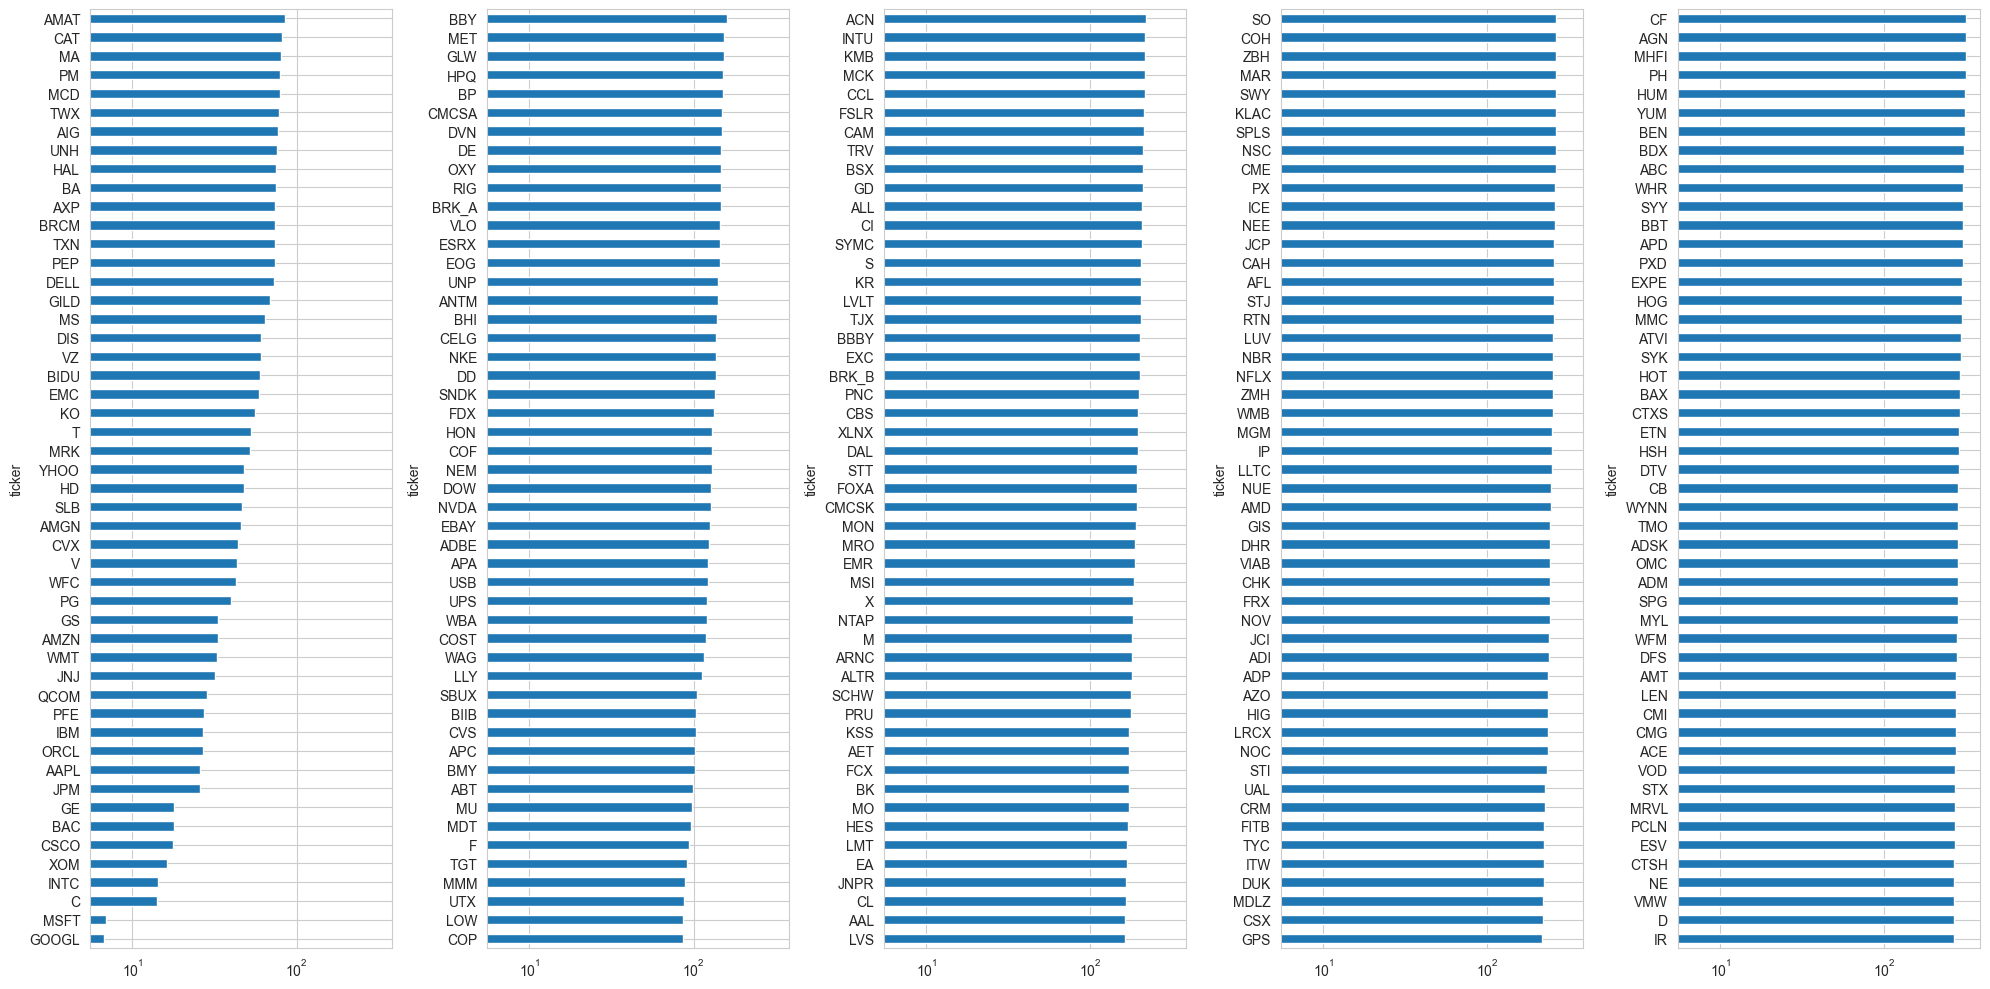

In [11]:
cutoffs = [0, 50, 100, 150, 200, 250]
fig, axes = plt.subplots(ncols=5, figsize=(20, 10), sharex=True)
axes = axes.flatten()

for i, cutoff in enumerate(cutoffs[1:], 1):
    top_500.iloc[cutoffs[i-1]:cutoffs[i]].sort_values().plot.barh(logx=True, ax=axes[i-1])
fig.tight_layout()

## Remove outliers based on daily returns

In [12]:
daily_returns = data.groupby('ticker').close.pct_change()

In [13]:
daily_returns.describe(percentiles=[.00001, .0001, .001, .999, .9999, .99999]).iloc[1:]

mean        0.000652
std         0.027345
min        -0.728859
0.001%     -0.507202
0.01%      -0.291512
0.1%       -0.151676
50%         0.000349
99.9%       0.170642
99.99%      0.332251
99.999%     0.628086
max        12.164251
Name: close, dtype: float64

Why not clip instead of remove outliers.

In [14]:
outliers = daily_returns[(daily_returns < daily_returns.quantile(.00001)) |
                         (daily_returns > daily_returns.quantile(.99999))]

In [15]:
len(outliers)

44

In [16]:
len(outliers.index.unique("ticker"))

30

In [17]:
data = data.drop(outliers.index.unique('ticker'), level='ticker')

## Compute returns

In [18]:
by_ticker = data.groupby(level='ticker')

In [19]:
time_steps = [1, 3, 5, 10, 21, 42, 63, 126, 252]
for t in time_steps:
    data[f'ret_{t:02}'] = by_ticker.close.pct_change(t) 

In [20]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2043147 entries, ('A', Timestamp('2000-01-03 00:00:00')) to ('ZMH', Timestamp('2015-06-26 00:00:00'))
Data columns (total 14 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   open     2043147 non-null  float64
 1   high     2043147 non-null  float64
 2   low      2043147 non-null  float64
 3   close    2043147 non-null  float64
 4   volume   2043147 non-null  float64
 5   ret_01   2042677 non-null  float64
 6   ret_03   2041737 non-null  float64
 7   ret_05   2040797 non-null  float64
 8   ret_10   2038447 non-null  float64
 9   ret_21   2033277 non-null  float64
 10  ret_42   2023407 non-null  float64
 11  ret_63   2013537 non-null  float64
 12  ret_126  1983927 non-null  float64
 13  ret_252  1924707 non-null  float64
dtypes: float64(14)
memory usage: 226.8+ MB


### Some Utilities for Adding TA indicators

In [21]:
by_ticker = data.groupby(level='ticker', group_keys=False)

## Bollinger Bands

In [22]:
def compute_bb_indicators(close, timeperiod=20, matype=0):
    high, mid, low = talib.BBANDS(close, 
                                  timeperiod=20,
                                  matype=matype)
    bb_up = high / close -1 # normalize with respect to close
    bb_low = low / close -1 # normalize with respect to close
    squeeze = (high - low) / close
    return pd.DataFrame({'BB_UP': bb_up, 
                         'BB_LOW': bb_low, 
                         'BB_SQUEEZE': squeeze}, 
                        index=close.index)

data = (data.join(by_ticker
                  .close
                  .apply(compute_bb_indicators)))

In [23]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2043147 entries, ('A', Timestamp('2000-01-03 00:00:00')) to ('ZMH', Timestamp('2015-06-26 00:00:00'))
Data columns (total 17 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   open        2043147 non-null  float64
 1   high        2043147 non-null  float64
 2   low         2043147 non-null  float64
 3   close       2043147 non-null  float64
 4   volume      2043147 non-null  float64
 5   ret_01      2042677 non-null  float64
 6   ret_03      2041737 non-null  float64
 7   ret_05      2040797 non-null  float64
 8   ret_10      2038447 non-null  float64
 9   ret_21      2033277 non-null  float64
 10  ret_42      2023407 non-null  float64
 11  ret_63      2013537 non-null  float64
 12  ret_126     1983927 non-null  float64
 13  ret_252     1924707 non-null  float64
 14  BB_UP       2034217 non-null  float64
 15  BB_LOW      2034217 non-null  float64
 16  BB_SQUEEZE  2034217 non-null  float6

## Momentum Indicators

TA-Lib offers the following choices - feel free to experiment with as many as you like (but you don't have to..):

|Function|             Name|
|:---|:---|
|PLUS_DM|              Plus Directional Movement|
|MINUS_DM|             Minus Directional Movement|
|PLUS_DI|              Plus Directional Indicator|
|MINUS_DI|             Minus Directional Indicator|
|DX|                   Directional Movement Index|
|ADX|                  Average Directional Movement Index|
|ADXR|                 Average Directional Movement Index Rating|
|APO|                  Absolute Price Oscillator|
|PPO|                  Percentage Price Oscillator|
|AROON|                Aroon|
|AROONOSC|             Aroon Oscillator|
|BOP|                  Balance Of Power|
|CCI|                  Commodity Channel Index|
|CMO|                  Chande Momentum Oscillator|
|MACD|                 Moving Average Convergence/Divergence|
|MACDEXT|              MACD with controllable MA type|
|MACDFIX|              Moving Average Convergence/Divergence Fix 12/26|
|MFI|                  Money Flow Index|
|MOM|                  Momentum|
|RSI|                  Relative Strength Index|
|STOCH|                Stochastic|
|STOCHF|               Stochastic Fast|
|STOCHRSI|             Stochastic Relative Strength Index|
|TRIX|                 1-day Rate-Of-Change (ROC) of a Triple Smooth EMA|
|ULTOSC|               Ultimate Oscillator|
|WILLR|                Williams' %R|

### Average Directional Movement Index (ADX)

The ADX combines of two other indicators, namely the positive and directional indicators (PLUS_DI and MINUS_DI), which in turn build on the positive and directional movement (PLUS_DM and MINUS_DM). For additional details see [Wikipdia](https://en.wikipedia.org/wiki/Average_directional_movement_index) and [Investopedia](https://www.investopedia.com/articles/trading/07/adx-trend-indicator.asp).

In [24]:
dm_period = 14
adx_period = 14

data['PLUS_DI'] = by_ticker.apply(lambda x : talib.PLUS_DI(x.high, x.low, x.close, timeperiod=dm_period))
data['MINUS_DI'] = by_ticker.apply(lambda x : talib.MINUS_DI(x.high, x.low, x.close, timeperiod=dm_period))
data['ADX'] = by_ticker.apply(lambda x : talib.ADX(x.high,  x.low,  x.close, timeperiod=adx_period))
data['ADXR'] = by_ticker.apply(lambda x : talib.ADXR(x.high, x.low, x.close, timeperiod=dm_period))

### Absolute Price Oscillator (APO)

The absolute Price Oscillator (APO) is computed as the difference between two exponential moving averages (EMA) of price series, expressed as an absolute value. The EMA windows usually contain 26 and 12 data points, respectively.

In [25]:
data['APO'] = by_ticker.apply(lambda x : talib.APO(x.close, fastperiod=12, slowperiod=26, matype=0))

### Percentage Price Oscillator (PPO)

The Percentage Price Oscillator (APO) is computed as the difference between two exponential moving averages (EMA) of price series, expressed as a percentage value and thus comparable across assets. The EMA windows usually contain 26 and 12 data points, respectively. 

In [26]:
data['PPO'] = by_ticker.apply(lambda x : talib.PPO(x.close, fastperiod=12, slowperiod=26, matype=1))

### Aroon Oscillator

#### Aroon Up/Down Indicator

The indicator measures the time between highs and the time between lows over a time period. It computes an AROON_UP and an AROON_DWN indicator as follows:

$$
\begin{align*}
\text{AROON_UP}&=\frac{T-\text{Periods since T period High}}{T}\times 100\\
\text{AROON_DWN}&=\frac{T-\text{Periods since T period Low}}{T}\times 100
\end{align*}
$$

#### Aroon Oscillator

The Aroon Oscillator is simply the difference between the Aroon Up and Aroon Down indicators.

In [27]:
data['AROONOSC'] = by_ticker.apply(lambda x : talib.AROONOSC(high=x.high, low=x.low, timeperiod=14))

### Balance Of Power (BOP)

The Balance of Power (BOP) intends to measure the strength of buyers relative to sellers in the market by assessing the ability of each side to drive prices. It is computer as the difference between the close and the open price, divided by the difference between the high and the low price: 

$$
\text{BOP}_t= \frac{P_t^\text{Close}-P_t^\text{Open}}{P_t^\text{High}-P_t^\text{Low}}
$$

In [28]:
data['BOP'] = by_ticker.apply(lambda x : talib.BOP(open=x.open, high=x.high, low=x.low, close=x.close))

### Commodity Channel Index (CCI)

The Commodity Channel Index (CCI) measures the difference between the current *typical* price, computed as the average of current low, high and close price and the historical average price. A positive (negative) CCI indicates that price is above (below) the historic average. When CCI is below zero, the price is below the hsitoric average. It is computed as:

$$
\begin{align*}
\bar{P_t}&=\frac{P_t^H+P_t^L+P_t^C}{3}\\
\text{CCI}_t & =\frac{\bar{P_t} - \text{SMA}(T)_t}{0.15\sum_{t=i}^T |\bar{P_t}-\text{SMA}(N)_t|/T}
\end{align*}
$$

In [29]:
data['CCI'] = by_ticker.apply(lambda x : talib.CCI(high=x.high, low=x.low, close=x.close, timeperiod=14))

### Moving Average Convergence/Divergence (MACD)

Moving Average Convergence Divergence (MACD) is a trend-following (lagging) momentum indicator that shows the relationship between two moving averages of a security’s price. It is calculated by subtracting the 26-period Exponential Moving Average (EMA) from the 12-period EMA.

The TA-Lib implementation returns the MACD value and its signal line, which is the 9-day EMA of the MACD. In addition, the MACD-Histogram measures the distance between the indicator and its signal line.

In [30]:
def compute_macd(close, fastperiod=12, slowperiod=26, signalperiod=9):
    macd, macdsignal, macdhist = talib.MACD(close,
                                            fastperiod=fastperiod,
                                            slowperiod=slowperiod,
                                            signalperiod=signalperiod)
    return pd.DataFrame({'MACD': macd,
                         'MACD_SIGNAL': macdsignal,
                         'MACD_HIST': macdhist},
                        index=close.index)

data = (data.join(by_ticker
                  .close
                  .apply(compute_macd)))

### Chande Momentum Oscillator (CMO)

The Chande Momentum Oscillator (CMO) intends to measure momentum on both up and down days. It is calculated as the difference between the sum of gains and losses over at time period T, divided by the sum of all price movement over the same period. It oscillates between +100 and -100.

In [31]:
data['CMO'] = by_ticker.apply(lambda x: talib.CMO(x.close, timeperiod=14))

### Money Flow Index

The Money Flow Index (MFI) incorporates price and volume information to identify overbought or oversold conditions.  The indicator is typically calculated using 14 periods of data. An MFI reading above 80 is considered overbought and an MFI reading below 20 is considered oversold.

In [32]:
data['MFI'] = by_ticker.apply(lambda x : talib.MFI(high=x.high, low=x.low, close=x.close, volume=x.volume, timeperiod=14))

### Relative Strength Index

RSI compares the magnitude of recent price changes across stocks to identify stocks as overbought or oversold. A high RSI (usually above 70) indicates overbought and a low RSI (typically below 30) indicates oversold. It first computes the average price change for a given number (often 14) of prior trading days with rising and falling prices, respectively as $\text{up}_t$ and $\text{down}_t$. Then, the RSI is computed as:
$$
\text{RSI}_t=100-\frac{100}{1+\frac{\text{up}_t}{\text{down}_t}}
$$



In [33]:
data['RSI'] = by_ticker.apply(lambda x : talib.RSI(x.close, timeperiod=14))

#### Stochastic RSI (STOCHRSI)

The Stochastic Relative Strength Index (STOCHRSI) is based on the RSI just described and intends to identify crossovers as well as overbought and oversold conditions. It compares the distance of the current RSI to the lowest RSI over a given time period T to the maximum range of values the RSI has assumed for this period. It is computed as follows:

$$
\text{STOCHRSI}_t= \frac{\text{RSI}_t-\text{RSI}_t^L(T)}{\text{RSI}_t^H(T)-\text{RSI}_t^L(T)}
$$

The TA-Lib implementation offers more flexibility than the original "Unsmoothed stochastic RSI" version by Chande and Kroll (1993). To calculate the original indicator, keep the `timeperiod` and `fastk_period` equal. 

The return value `fastk` is the unsmoothed RSI. The `fastd_period` is used to compute a smoothed STOCHRSI, which  is returned as `fastd`. If you do not care about STOCHRSI smoothing, just set `fastd_period` to 1 and ignore the `fastd` output.

Reference: "Stochastic RSI and Dynamic Momentum Index" by Tushar Chande and Stanley Kroll Stock&Commodities V.11:5 (189-199)


In [34]:
data['STOCHRSI'] = (by_ticker.apply(lambda x: talib.STOCHRSI(x.close,
                                                             timeperiod=14,
                                                             fastk_period=14,
                                                             fastd_period=3,
                                                             fastd_matype=0)[0]))

### Stochastic (STOCH)

A stochastic oscillator is a momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time. Stochastic oscillators are based on the idea that closing prices should confirm the trend.

For stochastic (STOCH), there are four different lines: `FASTK`, `FASTD`, `SLOWK` and `SLOWD`. The `D` is the signal line usually drawn over its corresponding `K` function.

$$
\begin{align*}
& K^\text{Fast}(T_K) & = &\frac{P_t-P_{T_K}^L}{P_{T_K}^H-P_{T_K}^L}* 100 \\
& D^\text{Fast}(T_{\text{FastD}}) & = & \text{MA}(T_{\text{FastD}})[K^\text{Fast}]\\
& K^\text{Slow}(T_{\text{SlowK}}) & = &\text{MA}(T_{\text{SlowK}})[K^\text{Fast}]\\
& D^\text{Slow}(T_{\text{SlowD}}) & = &\text{MA}(T_{\text{SlowD}})[K^\text{Slow}]
\end{align*}
$$
  

The $P_{T_K}^L$, $P_{T_K}^H$, and $P_{T_K}^L$ are the extreme values among the last $T_K$ period.
 $K^\text{Slow}$ and $D^\text{Fast}$ are equivalent when using the same period. 

In [35]:
def compute_stoch(x, fastk_period=14, slowk_period=3, 
                  slowk_matype=0, slowd_period=3, slowd_matype=0):
    slowk, slowd = talib.STOCH(x.high, x.low, x.close,
                           fastk_period=fastk_period,
                           slowk_period=slowk_period,
                           slowk_matype=slowk_matype,
                           slowd_period=slowd_period,
                           slowd_matype=slowd_matype)
    return slowd/slowk-1

data['STOCH'] = by_ticker.apply(compute_stoch)
data.loc[data.STOCH.abs() > 1e5, 'STOCH'] = np.nan

### Ultimate Oscillator (ULTOSC)

The Ultimate Oscillator (ULTOSC), developed by Larry Williams, measures the average difference of the current close to the previous lowest price over three time frames (default: 7, 14, and 28) to avoid overreacting to short-term price changes and incorporat short, medium, and long-term market trends. It first computes the buying pressure, $\text{BP}_t$, then sums it over the three periods $T_1, T_2, T_3$, normalized by the True Range ($\text{TR}_t$.
$$
\begin{align*}
\text{BP}_t & = P_t^\text{Close}-\min(P_{t-1}^\text{Close}, P_t^\text{Low})\\ 
\text{TR}_t & = \max(P_{t-1}^\text{Close}, P_t^\text{High})-\min(P_{t-1}^\text{Close}, P_t^\text{Low})
\end{align*}
$$

ULTOSC is then computed as a weighted average over the three periods as follows:
$$
\begin{align*}
\text{Avg}_t(T) & = \frac{\sum_{i=0}^{T-1} \text{BP}_{t-i}}{\sum_{i=0}^{T-1} \text{TR}_{t-i}}\\
\text{ULTOSC}_t & = 100*\frac{4\text{Avg}_t(7) + 2\text{Avg}_t(14) + \text{Avg}_t(28)}{4+2+1}
\end{align*}
$$

In [36]:
def compute_ultosc(x, timeperiod1=7, timeperiod2=14, timeperiod3=28):
    return talib.ULTOSC(x.high,
                        x.low,
                        x.close,
                        timeperiod1=timeperiod1,
                        timeperiod2=timeperiod2,
                        timeperiod3=timeperiod3)


data['ULTOSC'] = by_ticker.apply(compute_ultosc)

### Williams' %R (WILLR)

Williams %R, also known as the Williams Percent Range, is a momentum indicator that moves between 0 and -100 and measures overbought and oversold levels to identify entry and exit points. It is similar to the Stochastic oscillator and compares the current closing price $P_t^\text{Close}$ to the range of highest ($P_T^\text{High}$) and lowest ($P_T^\text{Low}$) prices over the last T periods (typically 14). The indicators is computed as:

$$
\text{WILLR}_t = \frac{P_T^\text{High}-P_t^\text{Close}}{P_T^\text{High}-P_T^\text{Low}}
$$


In [37]:
data['WILLR'] = by_ticker.apply(lambda x: talib.WILLR(x.high, x.low, x.close, timeperiod=14))

## Volume Indicators

|Function|             Name|
|:---|:---|
|AD|                   Chaikin A/D Line|
|ADOSC|                Chaikin A/D Oscillator|
|OBV|                  On Balance Volume|

### Chaikin A/D Line

The Chaikin Advance/Decline or Accumulation/Distribution Line (AD) is a volume-based indicator designed to measure the cumulative flow of money into and out of an asset. The indicator assumes that the degree of buying or selling pressure can be determined by the location of the close, relative to the high and low for the period. There is buying (sellng) pressure when a stock closes in the upper (lower) half of a period's range. The intention is to signal a change in direction when the indicator diverges from the security price.

The Accumulation/Distribution Line is a running total of each period's Money Flow Volume. It is calculated as follows:

1. The Money Flow Multiplier (MFI) is the relationship of the close to the high-low range:
2. The MFI is multiplied by the period's volume $V_t$ to come up with a Money Flow Volume (MFV). 
3. A running total of the Money Flow Volume forms the Accumulation Distribution Line:
$$
\begin{align*}
&\text{MFI}_t&=\frac{P_t^\text{Close}-P_t^\text{Low}}{P_t^\text{High}-P_t^\text{Low}}\\
&\text{MFV}_t&=\text{MFI}_t \times V_t\\
&\text{AD}_t&=\text{AD}_{t-1}+\text{MFV}_t
\end{align*}
$$

In [38]:
data['AD'] = by_ticker.apply(lambda x: talib.AD(x.high, x.low, x.close, x.volume)/x.volume.mean())

### Chaikin A/D Oscillator (ADOSC)

The Chaikin A/D Oscillator (ADOSC) is the Moving Average Convergence Divergence indicator (MACD) applied to the Chaikin A/D Line. The Chaikin Oscillator intends to predict changes in the Accumulation/Distribution Line.

It is computed as the difference between the 3-day exponential moving average and the 10-day exponential moving average of the Accumulation/Distribution Line.

In [39]:
data['ADOSC'] = by_ticker.apply(lambda x: talib.ADOSC(x.high,
                                                      x.low,
                                                      x.close,
                                                      x.volume,
                                                      fastperiod=3,
                                                      slowperiod=10)/x.rolling(14).volume.mean())

### On Balance Volume (OBV)

The On Balance Volume indicator (OBV) is a cumulative momentum indicator that relates volume to price change. It assumes that OBV changes precede price changes because smart money can be seen flowing into the security by a rising OBV. When the public then moves into the security, both the security and OBV will rise.

The current OBV is computed by adding (subtracting) the current volume to the last OBV if the security closes higher (lower) than the previous close.

$$
\text{OBV}_t = 
\begin{cases}
\text{OBV}_{t-1}+V_t & \text{if }P_t>P_{t-1}\\
\text{OBV}_{t-1}-V_t & \text{if }P_t<P_{t-1}\\
\text{OBV}_{t-1} & \text{otherwise}
\end{cases}
$$

In [40]:
data['OBV'] = by_ticker.apply(lambda x: talib.OBV(x.close, x.volume)/x.expanding().volume.mean())

## Volatility Indicators

|Function|             Name|
|:---|:---|
|TRANGE|               True Range|
|ATR|                  Average True Range|
|NATR|                 Normalized Average True Range|

### ATR

The Average True Range indicator (ATR) shows volatility of the market. It was introduced by Welles Wilder (1978)  and has been used as a component of numerous other indicators since. It aims to anticipate changes in trend such that the higher its value, the higher the probability of a trend change; the lower the indicator’s value, the weaker the current trend.

It is computed as the simple moving average for a period T of the True Range (TRANGE), which measures volatility as the absolute value of the largest recent trading range:
$$
\text{TRANGE}_t = \max\left[P_t^\text{High} - P_t^\text{low}, \left| P_t^\text{High} - P_{t-1}^\text{Close}\right|, \left| P_t^\text{low} - P_{t-1}^\text{Close}\right|\right]
$$

In [41]:
data['ATR'] = by_ticker.apply(lambda x: talib.ATR(x.high, x.low, x.close, timeperiod=14)/x.rolling(14).close.mean())

### NATR

The Normalized Average True Range (NATR) is a normalized version of the ATR computed as follows:

$$
\text{NATR}_t = \frac{\text{ATR}_t(T)}{P_t^\text{Close}} * 100
$$

Normalization make the ATR function more relevant in the folllowing scenarios:
- Long term analysis where the price changes drastically.
- Cross-market or cross-security ATR comparison.

In [42]:
data['NATR'] = by_ticker.apply(lambda x: talib.NATR(x.high, x.low, x.close, timeperiod=14))

In [43]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2043147 entries, ('A', Timestamp('2000-01-03 00:00:00')) to ('ZMH', Timestamp('2015-06-26 00:00:00'))
Data columns (total 41 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   open         2043147 non-null  float64
 1   high         2043147 non-null  float64
 2   low          2043147 non-null  float64
 3   close        2043147 non-null  float64
 4   volume       2043147 non-null  float64
 5   ret_01       2042677 non-null  float64
 6   ret_03       2041737 non-null  float64
 7   ret_05       2040797 non-null  float64
 8   ret_10       2038447 non-null  float64
 9   ret_21       2033277 non-null  float64
 10  ret_42       2023407 non-null  float64
 11  ret_63       2013537 non-null  float64
 12  ret_126      1983927 non-null  float64
 13  ret_252      1924707 non-null  float64
 14  BB_UP        2034217 non-null  float64
 15  BB_LOW       2034217 non-null  float64
 16  BB_SQUEEZE   20342

### Compute the outcome variable that we will aim to predict, namely the 1-day forward returns.

In [44]:
data['forward_return'] = by_ticker.ret_01.shift(-1)
data = data.dropna(subset=['forward_return'])

## Rolling Factor Betas

In [45]:
factor_data = (web.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench', 
                              start=1998, end=2019)[0].rename(columns={'Mkt-RF': 'MARKET'}))
factor_data.index.names = ['date']

In [46]:
factor_data

,MARKET,SMB,HML,RMW,CMA,RF
date,,,,,,
1998-01-02,0.22,-0.11,-0.47,0.21,-0.14,0.021
1998-01-05,0.22,0.04,-0.27,0.04,-0.01,0.021
1998-01-06,-1.04,0.24,0.15,-0.38,0.13,0.021
1998-01-07,-0.38,-0.37,-0.21,-0.13,0.31,0.021
1998-01-08,-0.82,0.19,-0.14,0.08,0.29,0.021
...,...,...,...,...,...,...
2018-12-24,-2.55,0.92,-0.49,-0.33,-0.34,0.011
2018-12-26,5.06,-0.19,-1.01,-0.21,-1.08,0.011
2018-12-27,0.78,-0.71,-0.13,-0.14,0.10,0.011


In [47]:
factors = factor_data.columns[:-1]
factors

Index(['MARKET', 'SMB', 'HML', 'RMW', 'CMA'], dtype='object')

In [48]:
t = 1
ret = f'ret_{t:02}'
windows = [63, 252]

In [50]:
for window in windows:
    print(window)
    betas = []
    for ticker, df in by_ticker:
        model_data = df[[ret]].merge(factor_data, on='date').dropna()
        model_data[ret] -= model_data.RF

        rolling_ols = RollingOLS(endog=model_data[ret], exog=sm.add_constant(model_data[factors]), window=window)
        factor_model = rolling_ols.fit(params_only=True).params.rename(columns={'const':'ALPHA'})
        result = factor_model.assign(ticker=ticker).set_index('ticker', append=True).swaplevel()
        betas.append(result)
    betas = pd.concat(betas).rename(columns=lambda x: f'{x}_{window:02}')
    data = data.join(betas)

63
252


### Feature Engineered data

In [51]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2042677 entries, ('A', Timestamp('2000-01-03 00:00:00')) to ('ZMH', Timestamp('2015-06-25 00:00:00'))
Data columns (total 54 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   open            2042677 non-null  float64
 1   high            2042677 non-null  float64
 2   low             2042677 non-null  float64
 3   close           2042677 non-null  float64
 4   volume          2042677 non-null  float64
 5   ret_01          2042207 non-null  float64
 6   ret_03          2041267 non-null  float64
 7   ret_05          2040327 non-null  float64
 8   ret_10          2037977 non-null  float64
 9   ret_21          2032807 non-null  float64
 10  ret_42          2022937 non-null  float64
 11  ret_63          2013067 non-null  float64
 12  ret_126         1983457 non-null  float64
 13  ret_252         1924237 non-null  float64
 14  BB_UP           2033747 non-null  float64
 15  BB_LOW     

In [52]:
data

open        high         low       close     volume  \
ticker date                                                                    
A      2000-01-03   53.726454   53.856080   45.969377   49.121329  3343600.0   
       2000-01-04   46.481058   46.992738   44.175084   45.369006  3408500.0   
       2000-01-05   45.198445   45.239380   41.828176   41.998737  4119200.0   
       2000-01-06   42.046493   42.298923   39.658651   40.934441  1812900.0   
       2000-01-07   40.293135   44.986951   40.252200   44.345645  2016900.0   
...                       ...         ...         ...         ...        ...   
ZMH    2015-06-19  113.400000  113.770000  112.570000  112.660000  1616619.0   
       2015-06-22  113.280000  113.915000  112.980000  113.400000   825030.0   
       2015-06-23  113.700000  113.770000  112.200000  112.680000   825724.0   
       2015-06-24  112.500000  115.500000  112.160100  113.520000  3486819.0   
       2015-06-25  113.530000  114.210000  112.920000  113.270000  1581017.0   

                     ret_01    ret_03    ret_05    ret_10    ret_21  ...  \
ticker date                                                          ...   
A      2000-01-03       NaN       NaN       NaN       NaN       NaN  ...   
       2000-01-04 -0.076389       NaN       NaN       NaN       NaN  ...   
       2000-01-05 -0.074286       NaN       NaN       NaN       NaN  ...   
       2000-01-06 -0.025341 -0.166667       NaN       NaN       NaN  ...   
       2000-01-07  0.083333 -0.022556       NaN       NaN       NaN  ...   
...                     ...       ...       ...       ...       ...  ...   
ZMH    2015-06-19 -0.005649  0.000977  0.004100 -0.005210 -0.014693  ...   
       2015-06-22  0.006568  0.008000  0.015492  0.002298 -0.009261  ...   
       2015-06-23 -0.006349 -0.005472  0.001155  0.000355 -0.009581  ...   
       2015-06-24  0.007455  0.007634  0.009067 -0.001232  0.003802  ...   
       2015-06-25 -0.002202 -0.001146 -0.000265 -0.007361 -0.008751  ...   

                     SMB_63    HML_63    RMW_63    CMA_63  ALPHA_252  \
ticker date                                                            
A      2000-01-03       NaN       NaN       NaN       NaN        NaN   
       2000-01-04       NaN       NaN       NaN       NaN        NaN   
       2000-01-05       NaN       NaN       NaN       NaN        NaN   
       2000-01-06       NaN       NaN       NaN       NaN        NaN   
       2000-01-07       NaN       NaN       NaN       NaN        NaN   
...                     ...       ...       ...       ...        ...   
ZMH    2015-06-19  0.002304 -0.006470 -0.001953 -0.003231  -0.000196   
       2015-06-22  0.002165 -0.006439 -0.002221 -0.003754  -0.000185   
       2015-06-23  0.002435 -0.006865 -0.001911 -0.004312  -0.000192   
       2015-06-24  0.002835 -0.007425 -0.002250 -0.006146  -0.000113   
       2015-06-25  0.002750 -0.007451 -0.002341 -0.005670  -0.000155   

                   MARKET_252   SMB_252   HML_252   RMW_252   CMA_252  
ticker date                                                            
A      2000-01-03         NaN       NaN       NaN       NaN       NaN  
       2000-01-04         NaN       NaN       NaN       NaN       NaN  
       2000-01-05         NaN       NaN       NaN       NaN       NaN  
       2000-01-06         NaN       NaN       NaN       NaN       NaN  
       2000-01-07         NaN       NaN       NaN       NaN       NaN  
...                       ...       ...       ...       ...       ...  
ZMH    2015-06-19    0.010541 -0.000426 -0.007525 -0.001444  0.007250  
       2015-06-22    0.010547 -0.000417 -0.007514 -0.001437  0.007240  
       2015-06-23    0.010538 -0.000469 -0.007532 -0.001448  0.007159  
       2015-06-24    0.010420 -0.000501 -0.007378 -0.001368  0.006799  
       2015-06-25    0.010399 -0.000555 -0.007623 -0.001410  0.007254  

[2042677 rows x 54 columns]

## Persist results

In [53]:
with pd.HDFStore(DATA_STORE) as store:
    store.put('model_data', data)